# Import libraries

In [1]:
import openml

import openml, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pointbiserialr

from statsmodels.graphics.gofplots import qqplot
from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import numpy as np
import scipy.stats as ss
# pd.set_option("display.max_columns", 100)

# Get dataset

In [2]:
# OpenML dataset 31 (German Credit). download metadata + data
ds = openml.datasets.get_dataset(31)  # 'credit-g'  OpenML
print("Name:", ds.name)
print("Default target:", ds.default_target_attribute)
print("Version:", ds.version)

# data as pandas DataFrame + target 
X, y, categorical, _ = ds.get_data(
    target=ds.default_target_attribute, # what is target attribute 
    dataset_format="dataframe"      # pandas dataframe
)

df = X.copy()
df[ds.default_target_attribute] = y
df.head()


Name: credit-g
Default target: class
Version: 1


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951.0,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096.0,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870.0,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


There is no nan values in the dataset :)
### Rename attributes to be more intuitive

In [3]:
df = df.rename(columns={"installment_commitment": "installment_rate_category"})

# Start of EDA
## 1) Basic info (shapes, distribution ...)

In [4]:
print(df.shape)          # (1000, 21)
print("\n Basic info about dataset")
df.info()
print("\n")

target = ds.default_target_attribute

print(df[target].value_counts())


(1000, 21)

 Basic info about dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   checking_status            1000 non-null   category
 1   duration                   1000 non-null   uint8   
 2   credit_history             1000 non-null   category
 3   purpose                    1000 non-null   category
 4   credit_amount              1000 non-null   float64 
 5   savings_status             1000 non-null   category
 6   employment                 1000 non-null   category
 7   installment_rate_category  1000 non-null   uint8   
 8   personal_status            1000 non-null   category
 9   other_parties              1000 non-null   category
 10  residence_since            1000 non-null   uint8   
 11  property_magnitude         1000 non-null   category
 12  age                        1000 non-null   uint8   
 

## What is the quality of data? (NaN values, duplicites)

In [5]:
# nan values in every columns
nan_counts = df.isna().sum().sort_values(ascending=False)
print(nan_counts)
# print(nan_counts[nan_counts > 0])

# are any rows duplicated?
print("\nNumber of duplicated rows")
print(df.duplicated().sum())

# numeric attributes
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# categorical attributes
category_cols = df.select_dtypes(include=["object", "category"]).columns.drop(target, errors="ignore").tolist()
print(f"\nCategorical attributes:\n {category_cols}")




checking_status              0
property_magnitude           0
foreign_worker               0
own_telephone                0
num_dependents               0
job                          0
existing_credits             0
housing                      0
other_payment_plans          0
age                          0
residence_since              0
duration                     0
other_parties                0
personal_status              0
installment_rate_category    0
employment                   0
savings_status               0
credit_amount                0
purpose                      0
credit_history               0
class                        0
dtype: int64

Number of duplicated rows
0

Categorical attributes:
 ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


So we have no nan values and no duplicated data, what is great especially as we have only 1000 rows.

But we have to encode those categorical attributes




In [6]:
df[num_cols].describe().T 

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
installment_rate_category,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
num_dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


- Duration of some credits are really short - 4 months
- Credit amount - median is 2320, but max is 18424 -> normalization will be needed (right skew)
- Installment_rate_category is more like categorical attribute - range 1-4
- Residence_since also categorical attribute - range 1-4
- existing_credits - most people have 1-2 credits at the same time - max is 4 (maybe larger risk)

In [7]:
df[num_cols].notna().sum()

duration                     1000
credit_amount                1000
installment_rate_category    1000
residence_since              1000
age                          1000
existing_credits             1000
num_dependents               1000
dtype: int64

## Cardinality of categories

In [8]:
card = (
    df[category_cols]
    .nunique()
    .sort_values(ascending=False)
    .rename("n_unique")
    .to_frame()
)
card


,n_unique
purpose,10
credit_history,5
savings_status,5
employment,5
checking_status,4
personal_status,4
property_magnitude,4
job,4
other_parties,3
other_payment_plans,3


One-hot encoding is reasonable as attributes have just few unuqie values - low cardinality

In [9]:
print(df["job"].unique())

['skilled', 'unskilled resident', 'high qualif/self emp/mgmt', 'unemp/unskilled non res']
Categories (4, object): ['unemp/unskilled non res' < 'unskilled resident' < 'skilled' < 'high qualif/self emp/mgmt']


## Visualisations
### Normality of numeric data
D’Agostino K² (more robust for bigger N than Shapiro) 
- H_0 - date is normally distributed
- H_1 - data are not normally distributed
- p < 0.05 - declining hypothesis 0

,feature,k2,p_value,mean,std,skew,kurtosis
3,residence_since,22019.260017,0.000000e+00,2.845,1.103166,-0.272161,-1.380545
2,installment_rate_category,842.425283,1.174016e-183,2.973,1.118155,-0.530551,-1.210423
1,credit_amount,396.042171,1.001233e-86,3271.258,2821.325155,1.946702,4.265163
6,num_dependents,325.065355,2.587945e-71,1.155,0.361905,1.906579,1.635045
5,existing_credits,208.700530,4.800159e-46,1.407,0.577366,1.270666,1.590434
0,duration,156.054121,1.298010e-34,20.903,12.052784,1.092542,0.909195
4,age,133.888657,8.442042e-30,35.546,11.369779,1.019208,0.586811


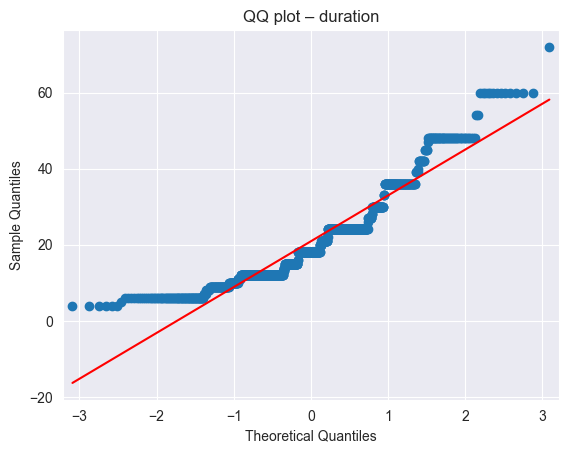

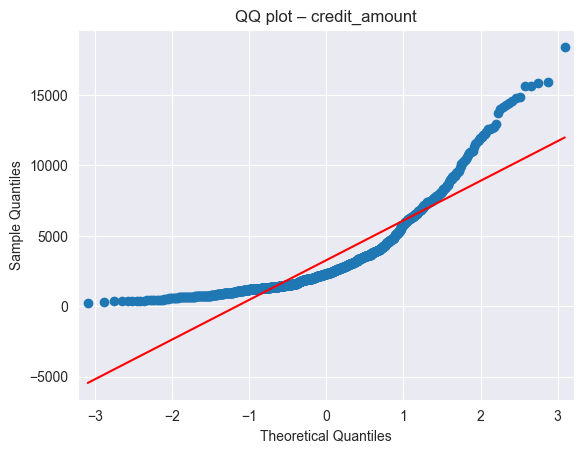

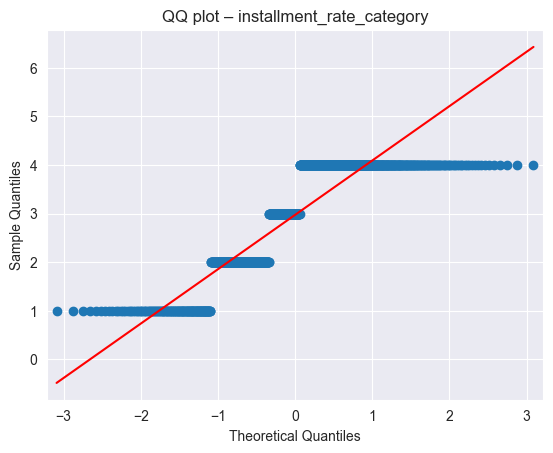

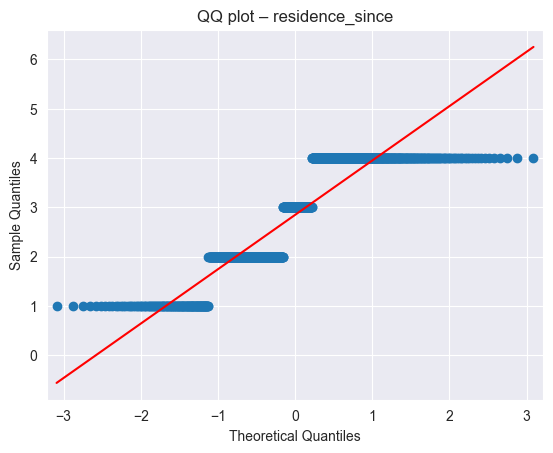

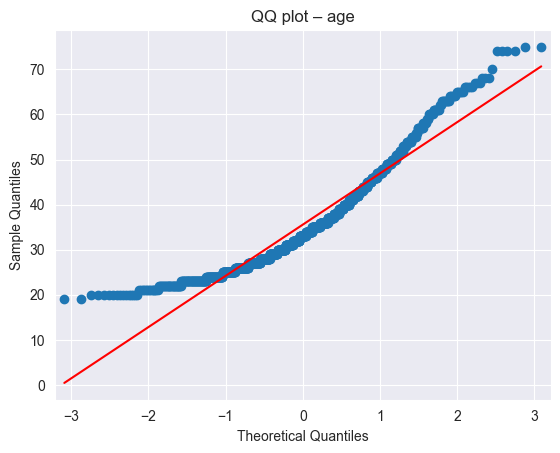

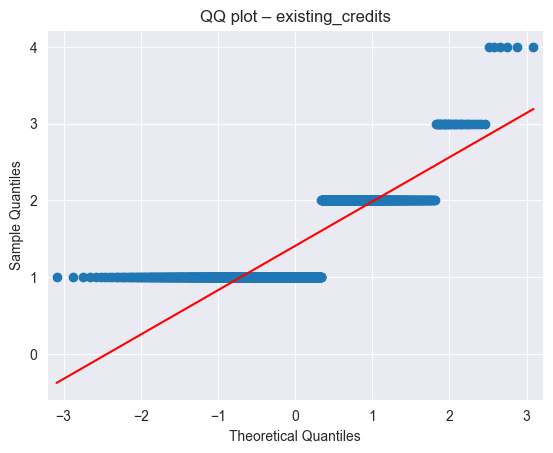

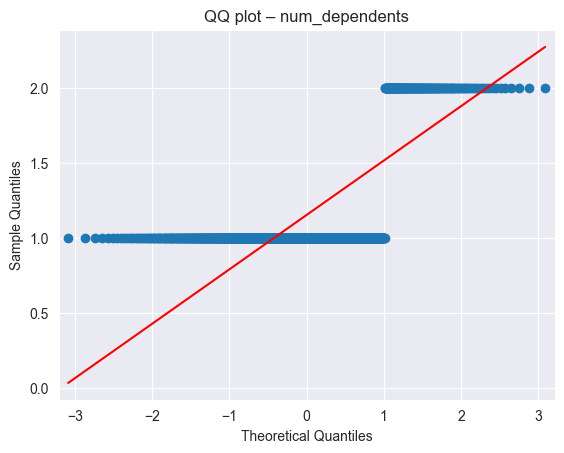

In [38]:


results_normality = []
for c in num_cols:
    x = pd.to_numeric(df[c], errors="coerce").astype(float)
    # D’Agostino K² (more robust for bigger N than Shapiro) 
    k2_stat, p = stats.normaltest(x)
    results_normality.append((c, k2_stat, p, np.mean(x), np.std(x), stats.skew(x), stats.kurtosis(x)))
norm_table = (pd.DataFrame(results_normality, columns=["feature","k2","p_value","mean","std","skew","kurtosis"])
                .sort_values("p_value"))
display(norm_table)

# QQ plots
for c in num_cols:
    fig = qqplot(df[c], line='s')
    plt.title(f"QQ plot – {c}")
    plt.show()


##### All attributes has p-value smaller than 0.05 so each is not normally distributed
- ##### Duration
Many people have short time credits
- ##### Credit amount
Many credit prices are very low
- ##### installment_rate_category, residence_since, existing_credits, num_dependents
These attributes are not numeric, they should be analyzed as categoric. So from now on, we will do so.

Tests and metrics - nonparametric comparations between classes (<b>Mann-Whitney</b> rather than ako T-test)



In [39]:
forced_categorical = [
    "installment_rate_category",
    "residence_since",
    "existing_credits",
    "num_dependents"
]

# delete our new categorical data from num cols
num_cols = [c for c in num_cols if c not in forced_categorical]

# add them to category
category_cols = category_cols + forced_categorical
category_cols = sorted(list(set(category_cols)))  

print(category_cols)
print(num_cols)

['checking_status', 'credit_history', 'employment', 'existing_credits', 'foreign_worker', 'housing', 'installment_rate_category', 'job', 'num_dependents', 'other_parties', 'other_payment_plans', 'own_telephone', 'personal_status', 'property_magnitude', 'purpose', 'residence_since', 'savings_status']
['duration', 'credit_amount', 'age']


### Histograms of numeric attributes

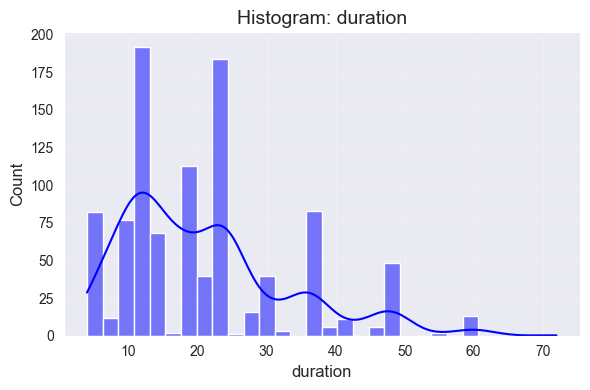

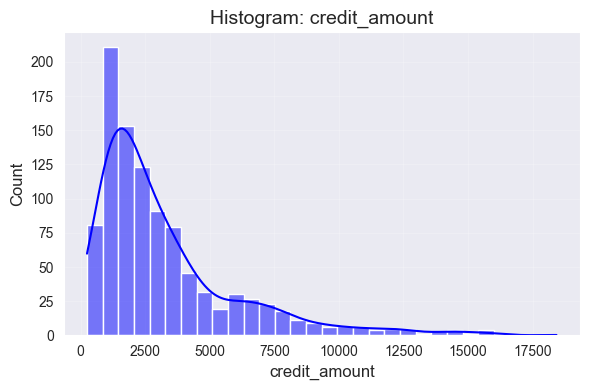

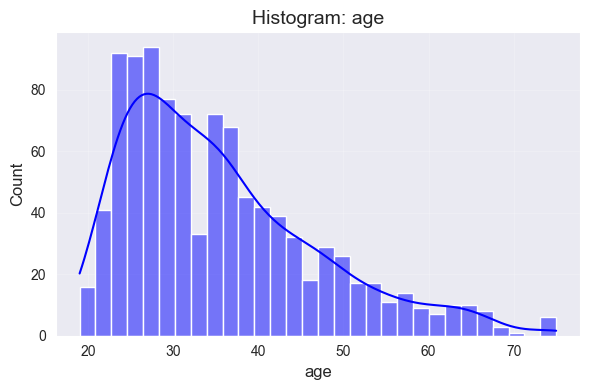

In [40]:
for c in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(
        data=df, 
        x=c, 
        bins=30, 
        kde=True,
        color="blue",      # choose a nice color
        edgecolor="white"     # improve bar contrast
    )
    plt.title(f"Histogram: {c}", fontsize=14)
    plt.xlabel(c, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


- Duration - Most loans are short: 12–24 months and very few goes above 48 months longer durations may correlate with higher risk or special cases
- Credit amount - Very right-skewed (long tail): a few customers take very large loans

## Categoric values

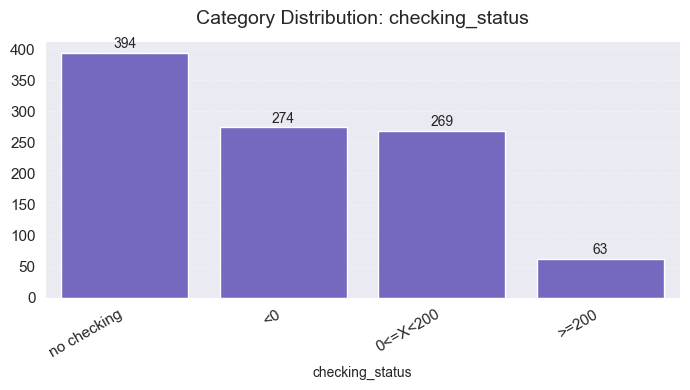

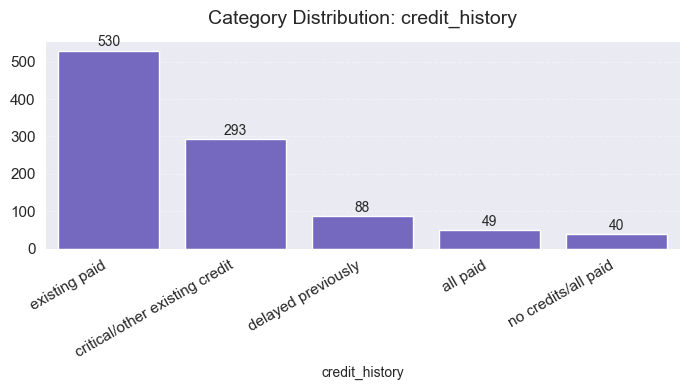

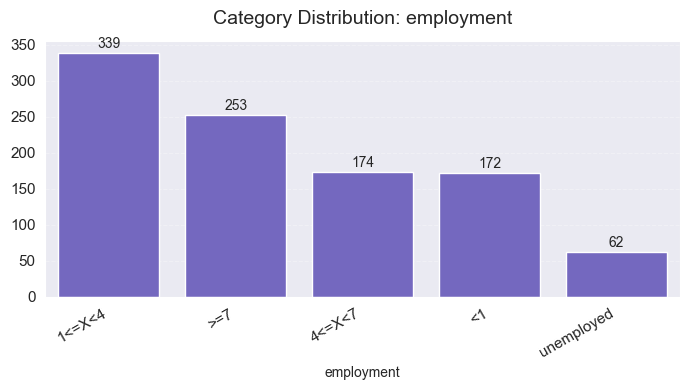

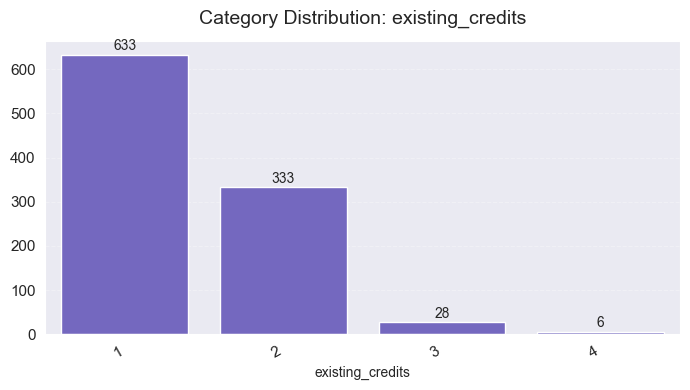

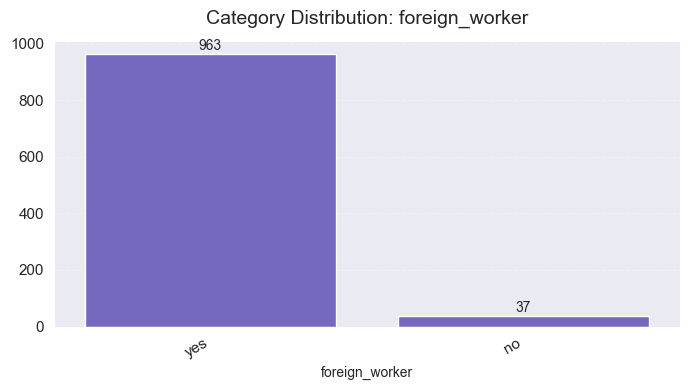

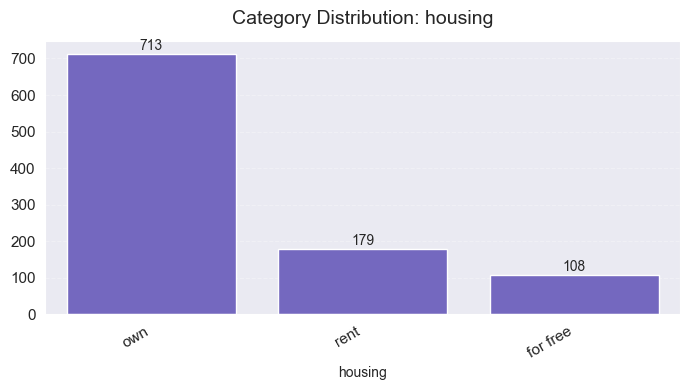

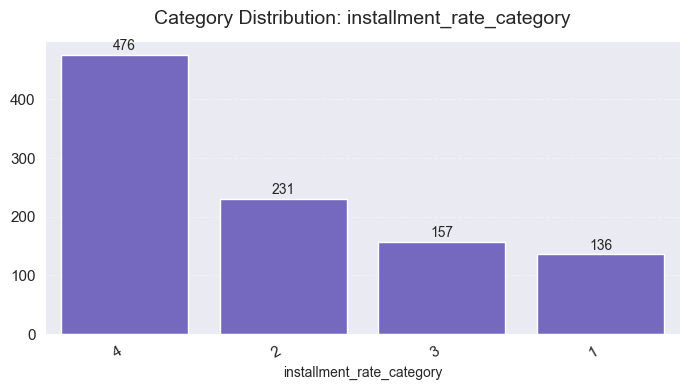

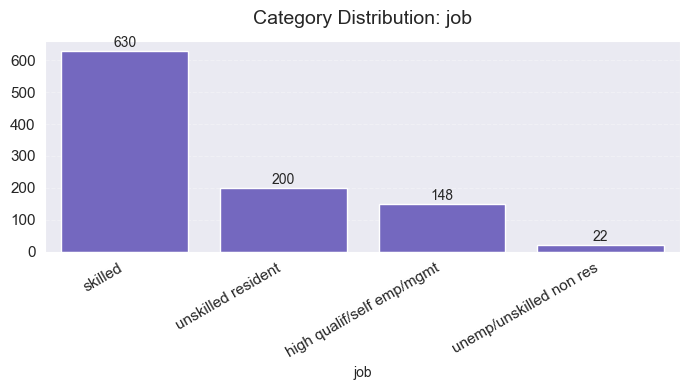

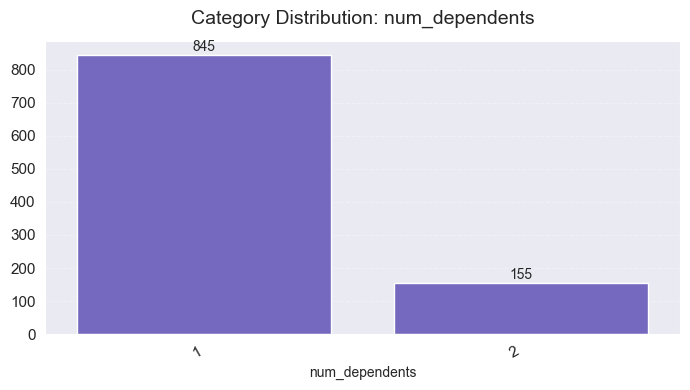

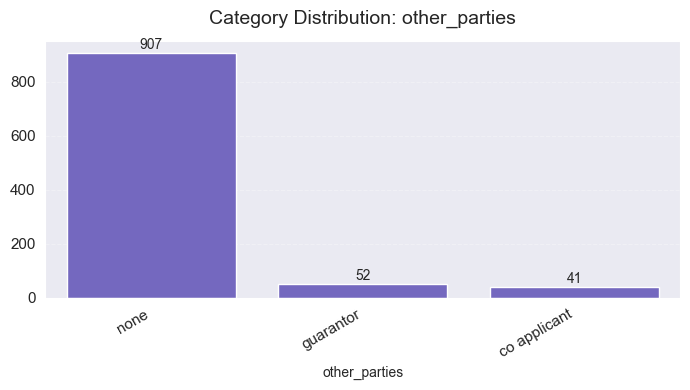

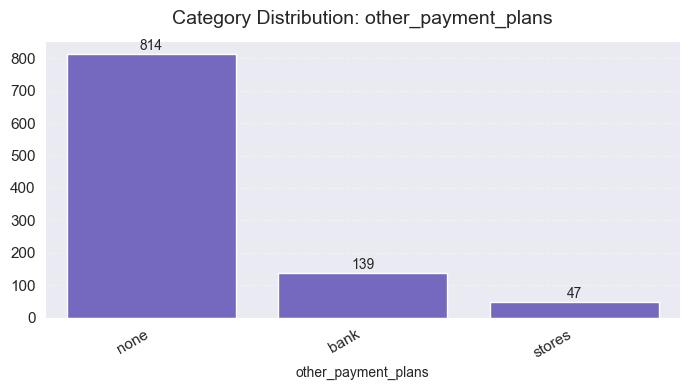

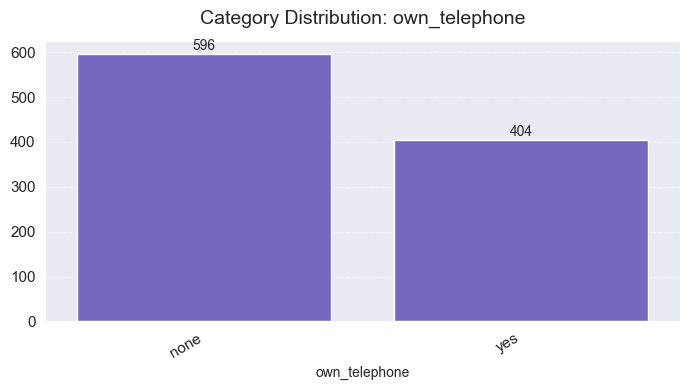

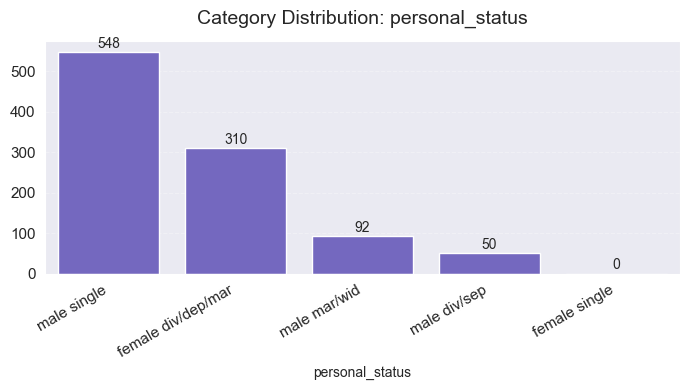

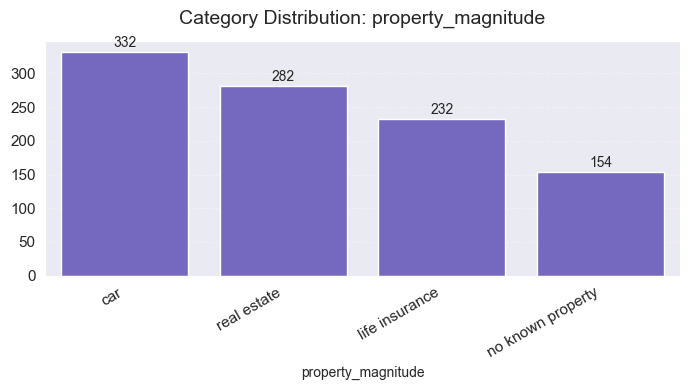

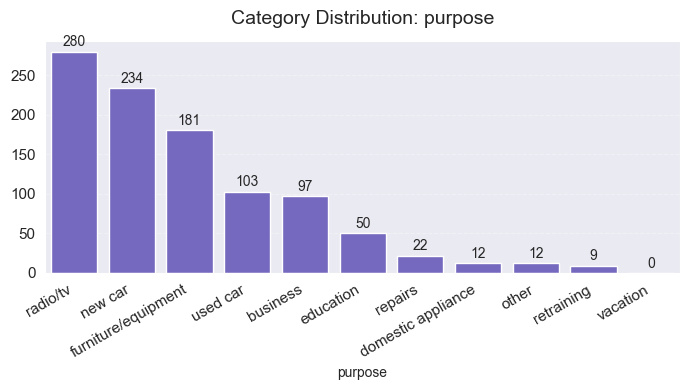

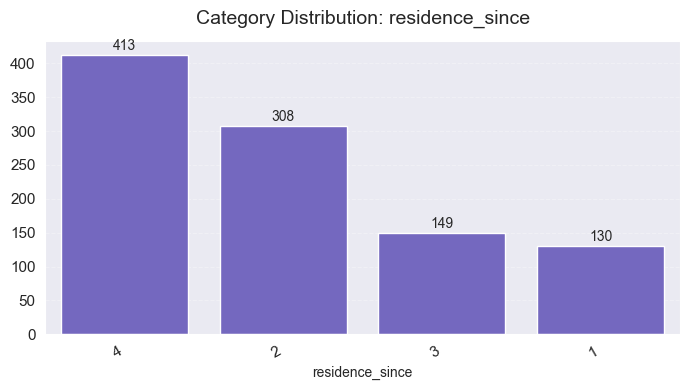

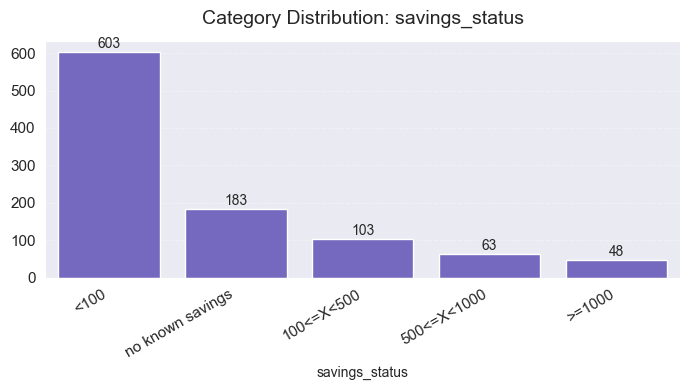

In [41]:
for c in category_cols:
    vc = df[c].value_counts()

    plt.figure(figsize=(7,4))

    sns.barplot(
        x=vc.index.astype(str),
        y=vc.values,
        color="slateblue",   # ✅ solid color fixes warning
        edgecolor="white"
    )

    plt.title(f"Category Distribution: {c}", fontsize=14, pad=12)
    plt.xticks(rotation=30, ha="right", fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis="y", linestyle="--", alpha=0.3)

    for i, v in enumerate(vc.values):
        plt.text(i, v + 3, str(v), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


## Violin plot based on target

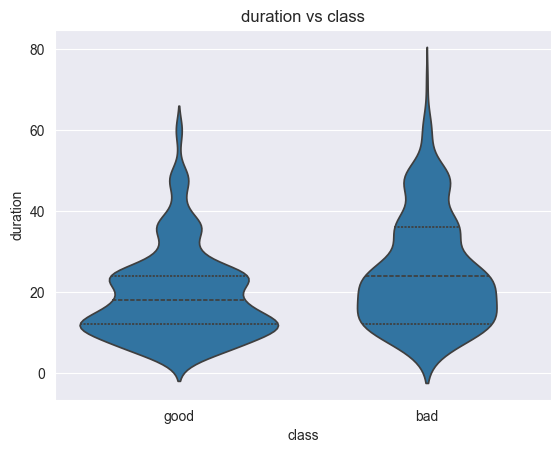

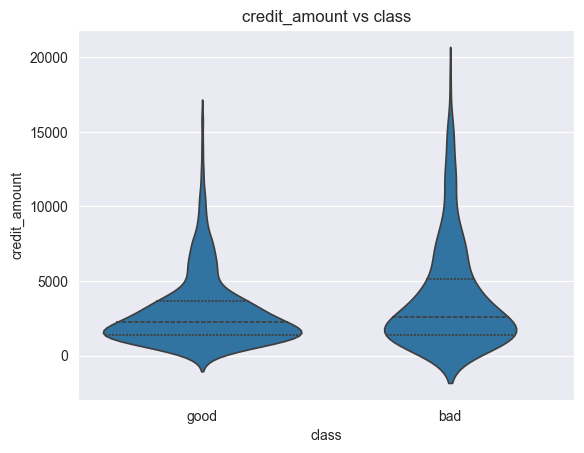

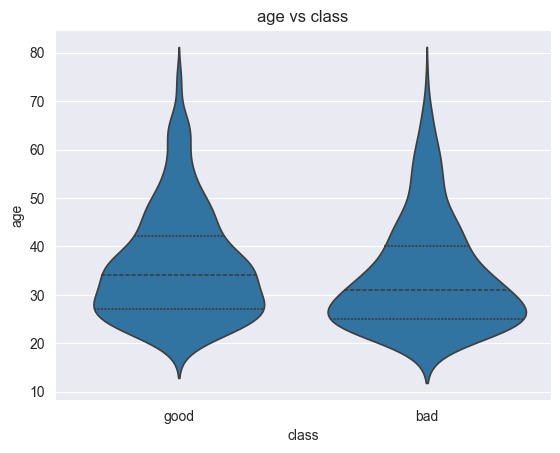

In [42]:
for c in num_cols:
    fig, ax = plt.subplots()
    sns.violinplot(data=df, x=target, y=c, inner="quartile")
    ax.set_title(f"{c} vs {target}")
    plt.show()


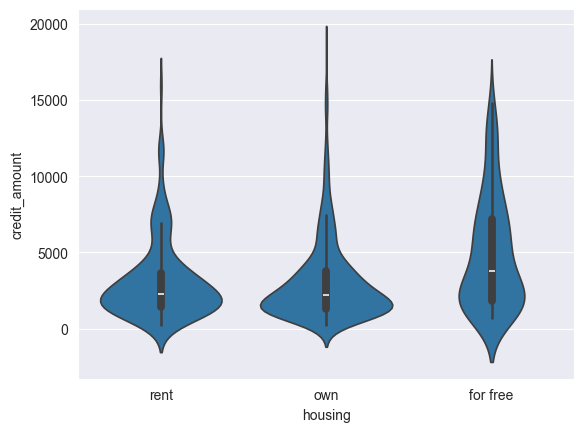

In [43]:
sns.violinplot(
    data=df,
    x="housing",          # kategória
    y="credit_amount"     # číslo
)
plt.show()

# Correlations and heatmap

Pearson - ako su si vsetky atributy navzajom podobne - predpoklada pribliznu linearitu a kontinuitu
Result is correlation on level of dummy columns - each value and target value correlation

In [50]:
# Convert the target into a binary numeric form
# print(df[target])
y_bin = (df[target].astype(str).str.lower() == "bad").astype(int)   
# print(y_bin)

# One-hot encode categorical features – drop_first=True prevents perfect
# multicollienarity (dummy trap)
df_enc = pd.get_dummies(df.drop(columns=[target]))

# correlation matrix
corr = df_enc.corr(numeric_only=True)

# correlation with target
corr_target = df_enc.assign(_y=y_bin) \
                    .corr(numeric_only=True)['_y'] \
                    .drop('_y') \
                    .sort_values(key=np.abs, ascending=False)

corr_target


checking_status_no checking                     -0.322436
checking_status_<0                               0.258333
duration                                         0.214927
credit_history_critical/other existing credit   -0.181713
savings_status_<100                              0.161007
                                                   ...   
num_dependents                                  -0.003015
residence_since                                  0.002967
other_parties_none                              -0.000751
purpose_vacation                                      NaN
personal_status_female single                         NaN
Name: _y, Length: 63, dtype: float64

Spearmen je robustensji - Sú numerické premenné monotónne závislé? (nemusí byť lineárne)

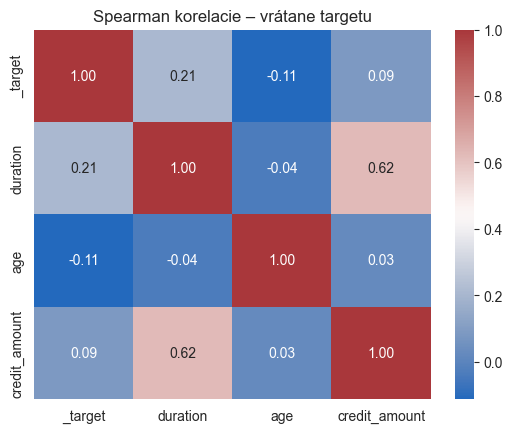

In [46]:
df_corr = df[num_cols].copy()
df_corr["_target"] = y_bin  # 0/1 verzia targetu

spearman_mat = df_corr.corr(method="spearman")
order = (spearman_mat["_target"].abs()
         .sort_values(ascending=False).index.tolist())
sns.heatmap(spearman_mat.loc[order, order], annot=True, fmt=".2f", cmap="vlag")

plt.title("Spearman korelacie – vrátane targetu")
plt.show()

# pb_df = pd.DataFrame(rows, columns=["feature","r_pb","p_value"]) \
#            .sort_values("r_pb", key=abs, ascending=False)
# 
# sns.barplot(data=pb_df, x="r_pb", y="feature")
# plt.title("Point-biserial korelacia s targetom")
# plt.axvline(0, color="black", linewidth=1)
# plt.show()



Silna vazba cim dlhsia splatnost, tym vacsi uver 

-0.31 vyssia katergoria splatky (percento z prijmu) ide typicky s mensim uverom vyššia kategória splátky (percento z príjmu)

# Mutual information

In [48]:

X_enc = pd.get_dummies(df.drop(columns=[target]), drop_first=True)  # MI needs just temporary encoding but final encoding will be done after EDA (also ordinal one)
mi = mutual_info_classif(X_enc, y_bin, discrete_features=X_enc.dtypes!=float, random_state=42)
mi_series = pd.Series(mi, index=X_enc.columns).sort_values(ascending=False)
mi_series


checking_status_no checking                      0.056778
duration                                         0.043914
age                                              0.031598
credit_history_critical/other existing credit    0.017686
credit_amount                                    0.011884
savings_status_no known savings                  0.009065
housing_own                                      0.008802
credit_history_all paid                          0.008186
property_magnitude_no known property             0.007492
checking_status_0<=X<200                         0.006945
other_payment_plans_none                         0.006149
purpose_radio/tv                                 0.005934
purpose_used car                                 0.005511
employment_<1                                    0.005420
savings_status_>=1000                            0.004295
foreign_worker_no                                0.004036
personal_status_male single                      0.003246
housing_for fr

kolko neurcitosti znizime ak pozname dany atribut?

checking_status_no - najsilnejsi

takisto je <b>duration a age</b> sama o sebe dost informativna

### Bad rate by category

In [17]:
def bad_rate_by_category(col):
    tmp = (
        df[[col]].assign(y=y_bin)
          .groupby(col, observed=False)['y'].mean()  
          .sort_values(ascending=False)
          .rename("bad_rate")
          .to_frame()
    )
    return tmp

# (napr. 'credit_history', 'checking_status', 'purpose')
for col in [c for c in category_cols if c.lower().startswith(("credit", "check", "purp"))][:3]:
    display(bad_rate_by_category(col))


,bad_rate
checking_status,
<0,0.492701
0<=X<200,0.390335
>=200,0.222222
no checking,0.116751


,bad_rate
credit_history,
no credits/all paid,0.625000
all paid,0.571429
existing paid,0.318868
delayed previously,0.318182
critical/other existing credit,0.170648


,bad_rate
purpose,
education,0.440000
other,0.416667
new car,0.380342
repairs,0.363636
business,0.350515
domestic appliance,0.333333
furniture/equipment,0.320442
radio/tv,0.221429
used car,0.165049


- ten kto je v minuse - velke rizikov         no checking (nema bezny ucet)
- prekvapivo vysoke riziko niekoho kto ma vsetky dlhy splatene (moze byt sum z par pripadov, mozno miesanie s vekom a podobne)
- 

# Cramer's V 
- 1 silny vztah s targetom

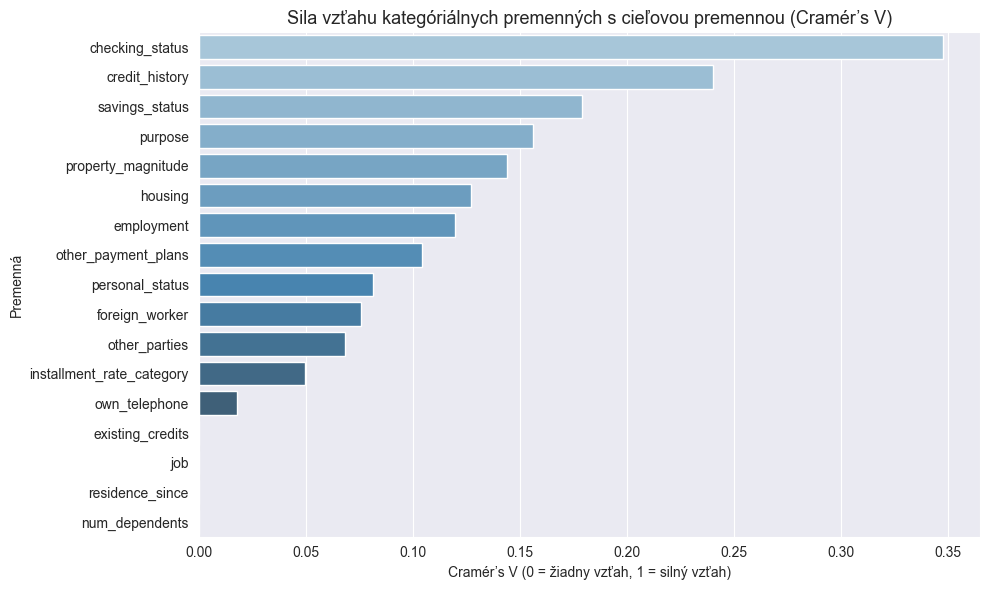

In [51]:
def cramers_v(x, y):
    ct = pd.crosstab(x, y)         # contigency table
    chi2, _, _, _ = ss.chi2_contingency(ct, correction=False)
    n = ct.to_numpy().sum()
    r, k = ct.shape
    phi2 = chi2 / n
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2_corr / max(1e-12, min(k_corr-1, r_corr-1)))

# --- Calculation Cramér’s for all categories ---
cramers_values = {c: cramers_v(df[c], y_bin) for c in category_cols}

# --- DataFrame for visualisations ---
cramers_df = pd.DataFrame({
    "Variable": list(cramers_values.keys()),
    "CramersV": list(cramers_values.values())
}).sort_values("CramersV", ascending=False)

# --- graph ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cramers_df,
    x="CramersV",
    y="Variable",
    palette="Blues_d"
)
plt.title("Sila vzťahu kategóriálnych premenných s cieľovou premennou (Cramér’s V)", fontsize=13)
plt.xlabel("Cramér’s V (0 = žiadny vzťah, 1 = silný vzťah)")
plt.ylabel("Premenná")
plt.tight_layout()
plt.show()


## Hypothesis testing  

**Hypoteza 0:** Medzi dobrými a zlými klientmi nie je rozdiel v dĺžke trvania úveru (duration). 

**Hypoteza 1:** Medzi dobrými a zlými klientmi existuje rozdiel v dĺžke trvania úveru (duration).

In [19]:
good_duration = df[df["class"] == "good"]["duration"]
bad_duration = df[df["class"] == "bad"]["duration"]

Využijeme Shapiro-Wilkom test aby sme zistili, či je rozdelenie normálne.

In [20]:
good = stats.shapiro(good_duration)
bad = stats.shapiro(bad_duration)
print(good)
print(bad)

ShapiroResult(statistic=np.float64(0.8940428396899388), pvalue=np.float64(1.5303819115920704e-21))
ShapiroResult(statistic=np.float64(0.9160708543398846), pvalue=np.float64(6.478560226120272e-12))


Kedze pri oboch testoch p < 0.5 - vyuzijeme MannWhitney U test.

In [21]:
stats.mannwhitneyu(good_duration, bad_duration, alternative="greater")

MannwhitneyuResult(statistic=np.float64(77995.5), pvalue=np.float64(0.9999999999601555))

Keďže p > 0.05 - je skoro až 1, nemáme dôkaz že by sa „dobrí“ klienti líšili od „zlých“ v dĺžke trvania úveru.

# Outliers (IQR) and transformations

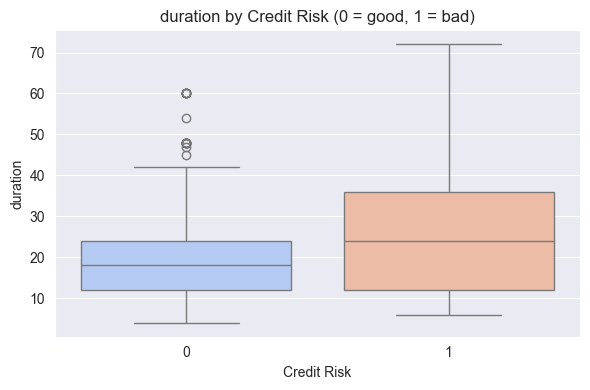

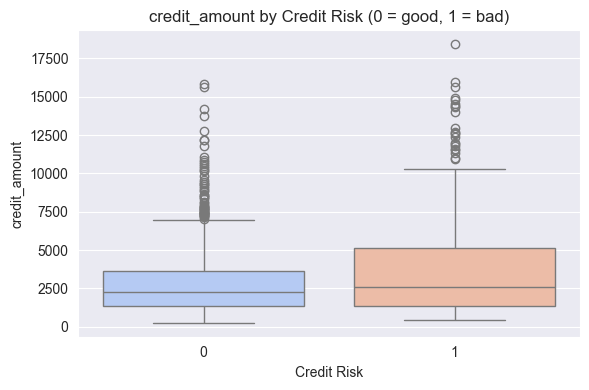

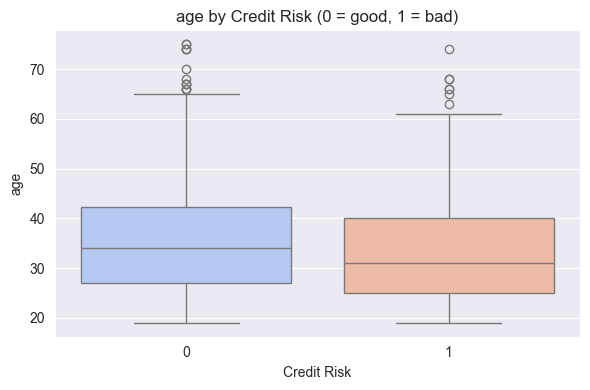

In [52]:
for c in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(
        data=df,
        x=y_bin,
        y=c,
        hue=y_bin,           
        palette="coolwarm",   
        showfliers=True
    )
    plt.title(f"{c} by Credit Risk (0 = good, 1 = bad)")
    plt.xlabel("Credit Risk")
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()


In [54]:
def iqr_outliers_count(x, k=1.5):
    x = x.astype(float)
    q1, q3 = np.nanpercentile(x, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return np.sum((x < lo) | (x > hi))

def mad_outliers_count(x, k=3.5):
    x = x.astype(float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med)) or 1e-9
    z = 0.6745 * (x - med) / mad
    return np.sum(np.abs(z) > k)

c = "credit_amount"
x_raw = pd.to_numeric(df[c], errors="coerce").values
x_log = np.log1p(x_raw.clip(min=0))

print("IQR outliers – raw:", iqr_outliers_count(x_raw))
print("IQR outliers – log1p:", iqr_outliers_count(x_log))
print("MAD outliers – raw:", mad_outliers_count(x_raw))
print("MAD outliers – log1p:", mad_outliers_count(x_log))


IQR outliers – raw: 72
IQR outliers – log1p: 1
MAD outliers – raw: 70
MAD outliers – log1p: 0


Ukazka transformacie pre credit_amount - log transformation


In [24]:
print(df["num_dependents"].unique())

[1 2]


In [25]:
print(df["duration"])       # if we want we can only scale it

0       6
1      48
2      12
3      42
4      24
       ..
995    12
996    30
997    12
998    45
999    45
Name: duration, Length: 1000, dtype: uint8


Comparation of credit_amount column after and before transformation

In [66]:
def mad_outliers(x, k=3.5):
    x = x.astype(float)
    med = np.median(x)
    mad = np.median(np.abs(x - med)) or 1e-9
    z = 0.6745 * (x - med) / mad
    return np.sum(np.abs(z) > k)

rob = {c: mad_outliers(df[c].values) for c in num_cols}
pd.Series(rob, name="n_outliers_MAD").sort_values(ascending=False)

# navrh transformacie
df_tf = df.copy()
for c in ["credit_amount"]:
    df_tf[f"log_{c}"] = np.log1p(df_tf[c])

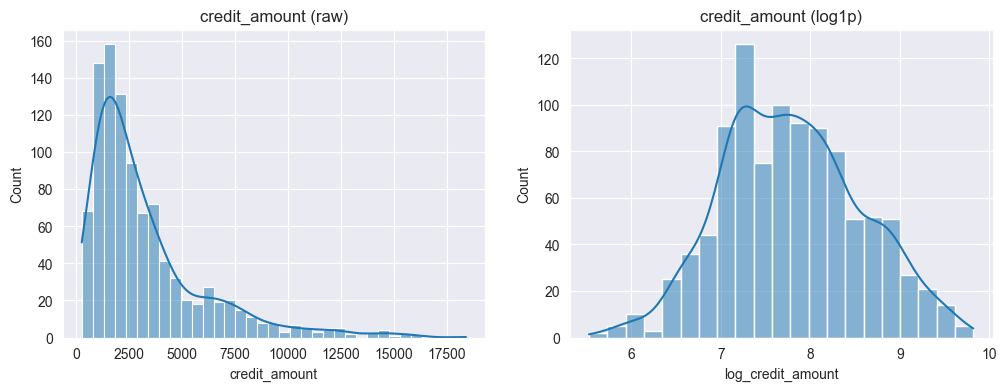

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df["credit_amount"], kde=True, ax=ax[0])
ax[0].set_title("credit_amount (raw)")

sns.histplot(df_tf["log_credit_amount"], kde=True, ax=ax[1])
ax[1].set_title("credit_amount (log1p)")

plt.show()


# Short summary for EDA

In [27]:
summary = {
    "n_rows": df.shape[0],
    "n_cols": df.shape[1],
    "n_num": len(num_cols),
    "n_cat": len(category_cols),
    "class_ratio": df[target].value_counts(normalize=True).to_dict(),
    "has_na": int(df.isna().any().any())
}
summary


{'n_rows': 1000,
 'n_cols': 21,
 'n_num': 7,
 'n_cat': 13,
 'class_ratio': {'good': 0.7, 'bad': 0.3},
 'has_na': 0}

Ciel a data

„German Credit“ dataset (1000 riadkov, 21 stlpcov vratane ciela class). Triedy su mierne nevyvazene (good ~70 % / bad ~30 %), preto budem pri modelovani pouzivat stratifikovane delenie.

Kvalita dat
Chybajuce hodnoty ani duplicity som nenasiel. Typy su rozumne: zopar numerickych stlpcov a viac kategorickych (nominálne aj ordinalne).

Distribucie a normalita

Numericke premenne su vyrazne nenormalne (pravostranny chvost najma pri credit_amount, zhluk okolo 12–24 mesiacov pri duration). Na porovnavanie skupin preto volim neparametricke testy a pri modelovaní robustne skalovanie; pre credit_amount davam log1p.

Vztah k cielu

Najsilnejsi signal maju kategoricke premenne ako checking_status a casti credit_history. Z numerickych niesu „striebornou gulou“, ale signal tam je: duration a credit_amount su informatívne, age ma slabsi negativny vztah. Bad-rate tabulky pre kategorie rozdiely pekne odhaluju.

Hypotezove testy

Kedze normalita v triedach neplati, pouzivam Mann–Whitney U namiesto t-testu. Samotna duration triedy vyrazne neoddeluje, ale v kombinacii s dalsimi znakmi pridava signal.

Outliery a transformacie

IQR najviac flaguje odlahlosti pri credit_amount (co riesim log1p) a pri niektorych nizko-kardinalitnych diskretnych stlpcoch, kde sa nespolieham len na IQR a pozeram aj robustne metriky (MAD) a bad-rate.

Priprava features

Kategoricke: one-hot pre nominalne; pre ordinalne zvazujem ordinalne kodovanie (aby som nezahodil poradie).
Numericke: robust scaler / standardizacia; kontrola multikolinearity po one-hot.
Zachovavam zmysluplne poradia (installment_rate, residence_since).

Implikacie pre modelovanie

Na baseline idem s logistickou regresiou (so skalovanim) a stromovymi metodami (RF/GB). Sledujem interakcie ako duration × credit_amount a checking_status × credit_history. Validacia bude stratifikovana, metriky ROC-AUC, PR-AUC a F1; pri nevyvazenosti pouzijem class weights.


# Normalizacia dat
- vyuzijeme MinMaxScaler

In [28]:


y = df[ds.default_target_attribute].map({'good': 1, 'bad': 0})  # zakódovanie 0/1
X = df.drop(columns=[ds.default_target_attribute])

# --- 2. Identifikácia číselných a kategóriálnych stĺpcov ---
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# --- 3. Transformácie ---
num_transformer = MinMaxScaler()                  # číselné normalizujeme do <0,1>
cat_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # kategórie

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

# --- 4. Aplikovanie transformácie ---
X_scaled = preprocessor.fit_transform(X)

# --- 5. Kontrola výsledku ---
print("Tvar vstupov pre neurónku:", X_scaled.shape)
print("Prvých 5 riadkov:\n", X_scaled[:5])

Tvar vstupov pre neurónku: (1000, 55)
Prvých 5 riadkov:
 [[0.05056674 0.         1.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         1.         0.
  0.         0.         0.         1.         0.         0.
  1.         0.         0.         0.         1.         0.
  1.         0.         0.         1.         0.         0.
  1.         0.         0.         0.         1.         0.
  1.        ]
 [0.31368989 1.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         1.         0.
  0.         1.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  1.         0.         0.   

# Model Training
- vyuzili sme MinMaxScaler pre normalizaciu dat
- pouzivame 2 hidden layer
    - ReLu - mame data od 0 po 1
    - output sigmoid - pre bin class
- Loss: Binary Cross Entropy - pre binarnu klasifikaciu
- optimizer: Adam
- Random Over Sampler - pre oversampling bad dat (povodne: 700 good 300 bad)


In [29]:
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
from skorch import NeuralNetClassifier

# ===== 1. DATA =====
y = df[ds.default_target_attribute].map({'good': 1, 'bad': 0}).astype(int)
X = df.drop(columns=[ds.default_target_attribute])

num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# ===== 2. MODEL =====
class MLP(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1) 
        )

    def forward(self, X):
        return self.net(X).squeeze(1)

# ===== 3. SPLIT =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

prep = preprocessor.fit(X_train)
X_train_tr = prep.transform(X_train).astype(np.float32)
X_test_tr  = prep.transform(X_test).astype(np.float32)

n_features = X_train_tr.shape[1]

# ===== 4. SKORCH WRAPPER =====
net = NeuralNetClassifier(
    module=MLP,
    module__num_features=n_features,
    criterion=nn.BCEWithLogitsLoss,
    max_epochs=1000,
    batch_size=32,
    optimizer=torch.optim.Adam,
    lr=0.001,
    iterator_train__shuffle=True,
    verbose=1
)

pipeline = Pipeline(steps=[
    # ("oversample", RandomOverSampler()),
    ("clf", net)
])

pipeline.fit(X_train_tr, y_train.values.astype(np.float32))

acc = pipeline.score(X_test_tr, y_test.values.astype(np.float32))
print(f"Test Accuracy: {acc:.4f}")


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6742       0.7000        0.6463  0.0613
      2        0.6179       0.7000        0.6067  0.0108
      3        0.5997       0.7000        0.5905  0.0121
      4        0.5875       0.7000        0.5785  0.0116
      5        0.5656       0.7000        0.5657  0.0112
      6        0.5513       0.7000        0.5524  0.0099
      7        0.5344       0.7125        0.5419  0.0094
      8        0.5089       0.7125        0.5345  0.0098
      9        0.5014       0.7312        0.5282  0.0094
     10        0.4946       0.7375        0.5258  0.0096
     11        0.4905       0.7375        0.5228  0.0102
     12        0.4704       0.7500        0.5234  0.0105
     13        0.4760       0.7562        0.5217  0.0096
     14        0.4843       0.7500        0.5169  0.0092
     15        0.4777       0.7562        0.5139  0.0096
     16        0.4628       0.7

In [30]:
preprocessor_std = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

prep_std = preprocessor_std.fit(X_train)

X_train_std = prep_std.transform(X_train).astype(np.float32)
X_test_std  = prep_std.transform(X_test).astype(np.float32)

pipe_std = Pipeline(steps=[
    # ("oversample", RandomOverSampler()),
    ("clf", net)
])

pipe_std.fit(X_train_std, y_train.values.astype(np.float32))
acc_std = pipe_std.score(X_test_std, y_test.values.astype(np.float32))
print(f"StandardScaler MLP Accuracy: {acc_std:.4f}")


Re-initializing module because the following parameters were re-set: num_features.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7053       0.6937        0.6880  0.0142
      2        0.6690       0.7000        0.6409  0.0140
      3        0.6255       0.7000        0.5995  0.0165
      4        0.5924       0.7000        0.5823  0.0268
      5        0.5794       0.7000        0.5709  0.0207
      6        0.5726       0.7000        0.5607  0.0170
      7        0.5571       0.7000        0.5461  0.0132
      8        0.5401       0.7000        0.5360  0.0142
      9        0.5190       0.7063        0.5250  0.0112
     10        0.5095       0.7438        0.5180  0.0107
     11        0.5018       0.7500        0.5130  0.0114
     12        0.4769       0.7438        0.5116  0.0113
     13        0.4823       0.7562        0.5081  0.0107
     14 

In [31]:
from sklearn.preprocessing import RobustScaler

preprocessor_std = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

prep_std = preprocessor_std.fit(X_train)

X_train_std = prep_std.transform(X_train).astype(np.float32)
X_test_std  = prep_std.transform(X_test).astype(np.float32)

pipe_std = Pipeline(steps=[
    ("oversample", RandomOverSampler()),
    ("clf", net)
])

pipe_std.fit(X_train_std, y_train.values.astype(np.float32))
acc_std = pipe_std.score(X_test_std, y_test.values.astype(np.float32))
print(f"StandardScaler MLP Accuracy: {acc_std:.4f}")


Re-initializing module because the following parameters were re-set: num_features.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6906       0.6071        0.6852  0.0149
      2        0.6778       0.6652        0.6684  0.0135
      3        0.6521       0.6964        0.6385  0.0144
      4        0.6180       0.7232        0.6017  0.0137
      5        0.5840       0.7366        0.5663  0.0147
      6        0.5512       0.7321        0.5428  0.0145
      7        0.5255       0.7277        0.5426  0.0148
      8        0.5206       0.7232        0.5222  0.0145
      9        0.5087       0.7321        0.5095  0.0136
     10        0.4961       0.7411        0.5102  0.0140
     11        0.4905       0.7455        0.5057  0.0149
     12        0.4865       0.7500        0.5021  0.0145
     13        0.4828       0.7500        0.4970  0.0134
     14 

In [32]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, confusion_matrix


# DATA
y = df[ds.default_target_attribute].map({'good': 1, 'bad': 0}).astype(int)
# X = df.drop(columns=[ds.default_target_attribute])

num_cols = X.select_dtypes(include=['float64', 'int64', 'uint8']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# PREPROCESSING
preprocessor_robust = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# PIPELINE
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_robust),
    # ('oversample', RandomOverSampler(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10))
])

# TRAIN
pipeline_rf.fit(X_train, y_train)

# PREDICT
y_pred = pipeline_rf.predict(X_test)
y_pred_proba = pipeline_rf.predict_proba(X_test)[:, 1]

# METRICS
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("RandomForest Accuracy:", round(accuracy, 4))
print("RandomForest ROC-AUC:", round(roc_auc, 4))
print("RandomForest PR-AUC:", round(pr_auc, 4))
print("RandomForest F1-Score:", round(f1, 4))
print("Confusion Matrix:")
print(conf_matrix)


RandomForest Accuracy: 0.75
RandomForest ROC-AUC: 0.7886
RandomForest PR-AUC: 0.8933
RandomForest F1-Score: 0.8322
Confusion Matrix:
[[ 26  34]
 [ 16 124]]
